# Analyzing AZ traffic stops

This tutorial is built in Python, a powerful programming language with a wide variety of applications. In addition to Python we will need to bring in some additional tools to make our jobs easier. These tools are:

- [Jupyter Notebook](http://jupyter.org/) - An environment for writing Python and other languages interactively.
- [Pandas](https://pandas.pydata.org/) - an open-source toolkit widely used for data analysis. 
- [Altair](https://altair-viz.github.io) - a charting library used in conjunction with Pandas to display data visually.

We're working in Jupyter Notebook right now. Each chunk of code or documentation is written into a cell. To run the code in each cell, press SHIFT + return. Cells should be run in order -- top to bottom. Otherwise, you may see error messages if you try to run code cells that rely on earlier cells that have not yet been run.

The first step in writing Python is to import tools like Pandas and Altair before we can start working with them. We also want to assign them shorter names so we don't have to type so much and because some abbreviations are commonly used -- might as well follow the convention to make your life easier.

In [1]:
import pandas as pd
import altair as alt

While we are at it, we are going to set an option so Pandas will display all the columns when we ask it to. We also have to enable Altair so we can see Altair's fancy charts later on.

In [2]:
pd.set_option('display.max_columns', 29)
alt.renderers.enable('notebook')

## Loading the data

Now that our tools are in place we can load the data. To do so we will use a **function** built into Pandas. It's easiest to think of functions as tools that conduct a task. These tools can take different **arguments**, which are variables that help functions complete their tasks. In this case we will use Pandas' `read_csv` function. In its simplest form, the function takes one argument - the path to the file we want to open.

We're basically going to tell Pandas where our data is located - in this case it is at `./data/az_2014.csv`.

We're also going to pass on additional argument to the `read_csv` function: a `dtype`. Since our spreadsheet data mostly consists of categories (e.g. the race of a driver) rather than numbers (e.g. the driver was going 53 mph) we are going to tell Pandas to import everything in the spreadsheet as if it was just text using the `dtype=str` argument. This has the added benefit of suppressing a warning issued by Pandas because it cannot determine the data types for each column.

Now, let's use Pandas to load our csv data into a new variable called `az_stops`.

In [3]:
az_stops = pd.read_csv('./data/az_2014.csv', dtype=str)

## Getting to know our data

One of the first steps in data analysis is getting a general feel for the data. What does it look like? How many columns are there? Is any data missing? Let's start answering some of these questions.

We'll use a function called `head` to look at the top of the dataset. It's very similar to the command-line `head` tool we used earlier.

In [4]:
az_stops.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2014-000001,AZ,2014-01-01,00:01,NaN,NaN,NaN,SR73 357 NA,NaN,F,NaN,NaN,Native American,Other,Speed/speed,Speeding,FALSE,NaN,NaN,FALSE,Citation,FALSE,7287,11-20,SR73,357,FALSE,4DSD 2006,N
1,AZ-2014-000002,AZ,2014-01-01,00:02,NaN,Pima County,04019,I10 255 NA,NaN,M,NaN,NaN,White,White,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,7288,0-10,I10,255,FALSE,12PU 2000,W
2,AZ-2014-000003,AZ,2014-01-01,00:03,NaN,NaN,NaN,NA NA 2501 W HWY 66 WINSLOW AZ,NaN,F,NaN,NaN,Native American,Other,"DUI,No insurance","DUI,Paperwork",FALSE,NaN,NaN,FALSE,Arrest,TRUE,6600,11-20,NaN,NaN,FALSE,2DSD 2005,N
3,AZ-2014-000004,AZ,2014-01-01,00:04,NaN,Maricopa County,04013,SR101 20 NA,NaN,M,NaN,NaN,Hispanic,Hispanic,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,5937,21-30,SR101,20,FALSE,4DSD 1997,H
4,AZ-2014-000005,AZ,2014-01-01,00:05,NaN,Maricopa County,04013,SR51 13.6 NA,NaN,F,NaN,NaN,White,White,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,4492,11-20,SR51,13.6,FALSE,NA NA,W


This gives us a general idea as to what columns we have and what the data looks like. Notice all the `NaN` (Not a Number) values. We will talk about those shortly. Keep in mind that this is only the first few rows. Now let's use a different function to take a more comprehensive look at the columns and how they are made up:

In [5]:
az_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508418 entries, 0 to 508417
Data columns (total 29 columns):
id                       508418 non-null object
state                    508418 non-null object
stop_date                508418 non-null object
stop_time                508418 non-null object
location_raw             32 non-null object
county_name              447212 non-null object
county_fips              447212 non-null object
fine_grained_location    508418 non-null object
police_department        0 non-null object
driver_gender            508418 non-null object
driver_age_raw           0 non-null object
driver_age               0 non-null object
driver_race_raw          508418 non-null object
driver_race              508418 non-null object
violation_raw            209257 non-null object
violation                209257 non-null object
search_conducted         508418 non-null object
search_type_raw          2650 non-null object
search_type              2650 non-null object


Now we have a list showing information about each column, including:

- The column name
- The number of records which have data in each column
- Whether or not there is missing or null data (see below)
- The data type of the column - in this case everything is listed as an `object`, which is how Pandas describes text fields.

Additionally we get information on how many records are in our data - this translates directly to the number of traffic stops we are analyzing. You will notice this matches up with the counts we checked earlier when extracting the data.

**Note:** One side effect of our importing our fields as `str` is that Pandas will handle missing, null or blank data (those `NaN` values from above) a little differently than it does by default. Normally Pandas would automatically exclude null values from any sort of analysis. We don't necessarily want that. It may be important to keep track of how many records do not have actual data in it for a given column. By telling Pandas that everything should be rendered as text when we import the data it allows us to keep null, missing or blank values in the analysis. But don't worry: we will talk about how to handle those later.

### Diving a little deeper

Now that we have a general sense of of our data, let's do some preliminary analysis to see what else we can learn.

One of the first things we want to learn is if there are any gaps in our data that we haven't been able to see so far. Let's start by taking a look at traffic stops by month. To do this we will work with the `stop_date` column, but we will need to convert it to the proper data type -- a Python `datetime` instead of an object -- before we can perform an analysis on it. Luckily, Pandas has a handy function to do that.

In [6]:
az_stops['stop_date'] = pd.to_datetime(az_stops['stop_date'])

OK, that syntax is pretty weird -- what just happened? Essentially, we told Pandas to rewrite the `stop_date` field for each row in our data.

Now that our `stop_date` column is in the correct format, we want to get a count of stops by month to check if we have the entire year. To do this we will use the `groupby` function. 

Since we only want to count stops by month we should try to count a column that has no missing data - in this case it would be the `id` column. We isolate that column by using the `az_stops['id']` syntax.

The `groupby` function takes several different arguments, but only one is required - which field you want to group by. In this case we need to group by the month of the `stop_date` column. Because we turned our stop_date into a fancy Python date, we can access that using this method: `az_stops.stop_date.dt.month`.

Lastly, since `groupby` is meant to aggregate data using different mathmatical functions (think sum, average, count, etc) we need to specify what kind of math we want to use when aggregating. In this case, we want to count how many stops are in each month, so we use `count()`.

In [7]:
stops_by_month = az_stops[['id']].groupby(by = az_stops.stop_date.dt.month).count()

stops_by_month

,id
stop_date,
1,50198
2,40752
3,41455
4,42330
5,41742
6,37698
7,40297
8,44082
9,39645


### Taking a visual look at our data

It's nice to have the table showing our counts by month, but sometimes we want more detail. Let's look at traffic stops by day of the yar. For that much data, we probably want to look at this visually rather than in a table, so let's build a bar chart.

First we need to do another `groupby`, but this time the syntax will be a bit different.

In [8]:
stops_by_day = az_stops[['stop_date','id']].groupby(by = 'stop_date', as_index = False).count()

# Even though our groupby ran on the whole data set, let's just look at the first few rows.
stops_by_day.head()

,stop_date,id
0,2014-01-01,1755
1,2014-01-02,1694
2,2014-01-03,1490
3,2014-01-04,1153
4,2014-01-05,1150


Before we draw the chart, let's change the name of the `id` column into something that makes sense.

In [9]:
stops_by_day.rename(columns = {'id' : 'traffic_stops'}, inplace = True)

# Let's see if that worked.
stops_by_day.head()

,stop_date,traffic_stops
0,2014-01-01,1755
1,2014-01-02,1694
2,2014-01-03,1490
3,2014-01-04,1153
4,2014-01-05,1150


Now we can draw the chart using Altair. Altair requires us to use several different functions tied together to display the chart. The first function is just starting up a chart and telling it what data we want to use. Then we tell it what type of chart we want (a line or fever chart in this case). Lastly we tell it what columns in our data should be used for the chart axes. 

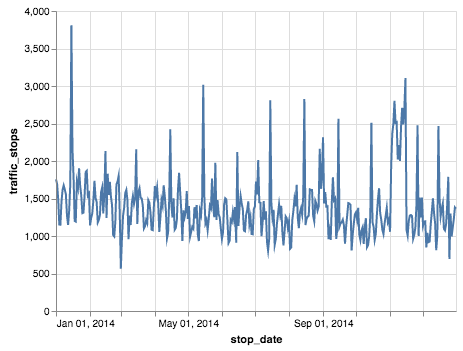

In [10]:
alt.Chart(stops_by_day).mark_line().encode(x = 'stop_date', y = 'traffic_stops')

That looks fine. We certainly can get a better idea of our data. But can we make it look better?

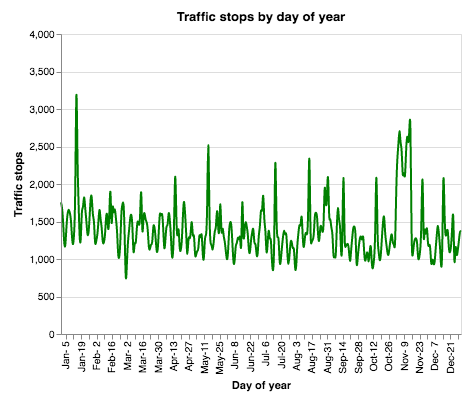

In [11]:
alt.Chart(
    stops_by_day, 
    padding = 10, 
    title = 'Traffic stops by day of year'
).mark_line(
    interpolate = 'basis', 
    color = 'green'
).encode(
    x = alt.X(
        'stop_date:T', 
        axis = alt.Axis(
            title = 'Day of year', 
            format = '%b-%e', 
            labelAngle = -90, 
            labelFlush = True, 
            tickCount = 26, 
            grid = False)), 
    y = alt.Y(
        'traffic_stops:Q', 
        axis = alt.Axis(
            title = 'Traffic stops'))
    )

There's something fishy here. You can see there are spikes throughout the year where there are more stops than normal -- sometimes the stops nearly double from one day to the next. Let's see if we can find out more information about those spikes. We can do this by filtering the `stops_by_day` data to show only days where more than 2,000 stops occurred.

In [12]:
stops_by_day[stops_by_day['traffic_stops'] >= 2000]

,stop_date,traffic_stops
14,2014-01-15,3810
15,2014-01-16,2155
45,2014-02-15,2134
73,2014-03-15,2156
104,2014-04-15,2422
134,2014-05-15,3016
165,2014-06-15,2120
184,2014-07-04,2012
195,2014-07-15,2810
226,2014-08-15,2828


We really don't have a good answer to what is going on here. For some reason, traffic stops seem to spike towards the middle of the month. Sometimes it happens at the beginning of the month. Maybe some spikes could be related to holiday enforcement actions such as Fourth of July and Thanksgiving DUI checkpoints? But at this point, we don't know. This is a great example of a case where you would need to do additional reporting to try to figure out what's going on before publishing results of this data. However, this shouldn't impact our training analysis greatly because time is not a factor in what we want to uncover.

### Work on your own, part I

Now that we have taken a fairly in-depth look at the `stop_date` column, let's take a closer look at counties where the stops occurred. Use the `county_name` column to generate your own table of traffic stops throughout the state.

In [13]:
# do the group by
stops_by_county = az_stops[['county_name','id']].groupby(by = 'county_name', as_index = False).count()
stops_by_county

,county_name,id
0,Apache County,11550
1,Cochise County,27766
2,Coconino County,34147
3,Gila County,13966
4,Graham County,5282
5,Greenlee County,1285
6,La Paz County,14248
7,Maricopa County,149932
8,Mohave County,22962
9,Navajo County,24072


In [14]:
# change column names
stops_by_county.rename(columns = {'county_name' : 'county', 'id' : 'traffic_stops'}, inplace = True)
stops_by_county

,county,traffic_stops
0,Apache County,11550
1,Cochise County,27766
2,Coconino County,34147
3,Gila County,13966
4,Graham County,5282
5,Greenlee County,1285
6,La Paz County,14248
7,Maricopa County,149932
8,Mohave County,22962
9,Navajo County,24072


### Coming back

So now we have an idea of how many traffic stops occurred in each county. For the purposes of our analysis this actually means very little since we will be taking a look at the entire state. However if you wanted to localize this to your area it is probably a good idea to take a look at how many stops are occurring in your coverage area.

## Visualizing the results

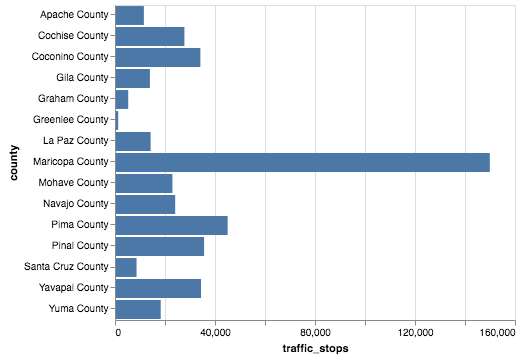

In [15]:
alt.Chart(stops_by_county).mark_bar().encode(x = 'traffic_stops', y = 'county')

Can we make this look better? First let's drop the " County" at the end of every county name.

In [16]:
stops_by_county['county'].replace(to_replace = ' County', value = '', regex = True, inplace = True)

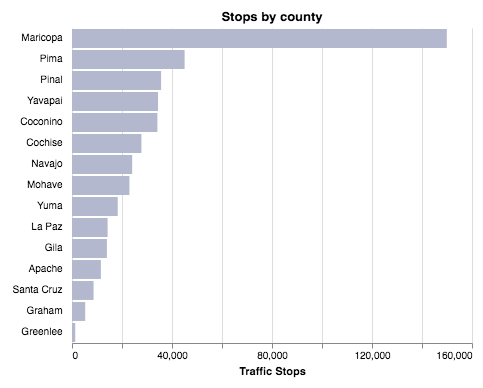

In [17]:
alt.Chart(
    stops_by_county, 
    padding = 10, 
    title = 'Stops by county'
).mark_bar(
    color = '#b4b8ce'
).encode(
    x = alt.X(
        'traffic_stops',
        axis = alt.Axis(title = "Traffic Stops")
    ), 
    y = alt.Y(
        'county', 
        sort = alt.SortField(
            field = 'traffic_stops', 
            op = 'sum', 
            order = 'descending'), 
        axis = alt.Axis(ticks = False, labelPadding = 10, title = None, domain = False))).configure_view(stroke = 'transparent')

## Digging into the demographics

Now we can start playing with demographic data that we have in the data set. Our initial look at the data showed us that there isn't any information on the age of the driver, but we do have pretty good data on gender and race/ethnicity. Rather than examining both gender and race separately, let's see if we can do an analysis on both columns at the same time.

To do this we will use what is called a pivot table. Those of you who have worked with Excel may be familiar with pivot tables. They are a way to restructure your data to provide a different perspective.

Before we get started though, let's do some housekeeping. The `driver_gender` column identifies gender by abbreviation. Let's change that to a full spelling. Earlier, we used `rename` to change the column name, but now we're changing the data, not the column name. So we'll use the `replace` function.

In [18]:
az_stops['driver_gender'].replace({'F' : 'Female', 'M' : 'Male'}, inplace = True)
az_stops[['driver_gender']].head()

,driver_gender
0,Female
1,Male
2,Female
3,Male
4,Female


Much better. While we are at it let's take a peek at the `driver_race` column to see how race is coded.

In [19]:
az_stops[['driver_race']].head()

,driver_race
0,Other
1,White
2,Other
3,Hispanic
4,White


Now what we want to know is the number of stops by gender and race. Let's build our pivot table to show us that.

In [20]:
stops_by_sex_race = pd.pivot_table(az_stops, 
                                   columns = 'driver_gender', 
                                   index = 'driver_race', 
                                   values = 'id', 
                                   aggfunc = 'count')
stops_by_sex_race

driver_gender,Female,Male
driver_race,,
Asian,3097,9253
Black,8378,20594
Hispanic,35429,99974
Other,12703,23295
White,96813,198882


Now we have our results. But again, data presented this way is a bit difficult to for humans to read easily. So we should probably chart this out as well. First we have to clean the table up a bit. We need to get rid of the totals and restructure the dataframe a bit.

TODO: What does melt mean?

In [21]:
stops_by_sex_race = pd.DataFrame(stops_by_sex_race.to_records())

stops_by_sex_race = stops_by_sex_race.melt(id_vars = 'driver_race', var_name = 'driver_gender', value_name = 'traffic_stops')

stops_by_sex_race

,driver_race,driver_gender,traffic_stops
0,Asian,Female,3097
1,Black,Female,8378
2,Hispanic,Female,35429
3,Other,Female,12703
4,White,Female,96813
5,Asian,Male,9253
6,Black,Male,20594
7,Hispanic,Male,99974
8,Other,Male,23295
9,White,Male,198882


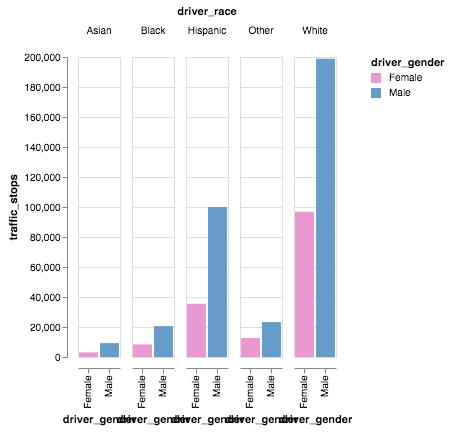

In [22]:
alt.Chart(stops_by_sex_race).mark_bar().encode(
    alt.X('driver_gender:N'),
    alt.Y('traffic_stops:Q'),
    color=alt.Color('driver_gender', scale=alt.Scale(range=["#EA98D2", "#659CCA"])),
    column = 'driver_race'
)

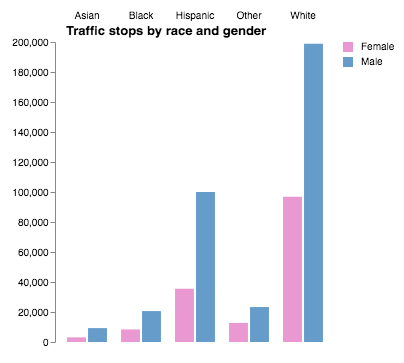

In [23]:
alt.Chart(stops_by_sex_race, padding = 10, title = "Traffic stops by race and gender").mark_bar().encode(
    alt.X('driver_gender:N', axis = alt.Axis(title = None, labels = False, ticks = False, grid = False, domain = False)),
    alt.Y('traffic_stops:Q', axis = alt.Axis(title = None, grid = False)),
    color=alt.Color('driver_gender', scale=alt.Scale(range=["#EA98D2", "#659CCA"]), legend = alt.Legend(title = None)),
    column = alt.Column('driver_race', header = alt.Header(title = None))
).configure_view(stroke = 'transparent')

## Do we have a story yet?

At this point it doesn't look like it. As you can see in the graphic above, whites account for a large majority of the stops. And men got stopped more than women, regardless of race. But what is wrong with this analysis?

In short it doesn't tell us whether or not minority groups are over- or under-represented in the data. To find that out we would need to compare stops by race to some other metric. One option would be Census data showing the racial make up of the state's population. Another choice would be to look at demographic breakdowns of licensed drivers. This sort of information is usually requested from the state's Department of Motor Vehicles.

However there is a flaw in this sort of analysis. These are stops conducted by the Arizona Department of Public Safety, which means most stops were conducted on highways or state routes. This means drivers stopped by the DPS are more likely to be from outside the state – or given the proximity to the border – from Mexico. So population figures from a secondary source would not necessarily represent the population on the road.

Fortunately there is another metric in the data that we can use to look for bias – search patterns.

## Analyzing search patterns

Another metric that could show bias is whether or not a search was conducted during the course of the traffic stop. For our purposes there are three different types of searches – probable cause, warrant and consent searches. The ones we want to focus on are consent searches. This type of search does not require a search warrant, and the officer most likely does not have probable cause. As such this search is completely up to the officer's discretion.

There is a `consent_search` column in the data set, but let's explore a bit more before we dive into our analysis.

Let's start by getting a better feel for how many searches were conducted overall. Rather than do a `groupby` let's build a pivot table so we can get some totals.

In [24]:
pd.pivot_table(az_stops, index = 'search_conducted', values = 'id', aggfunc = 'count', margins = True, margins_name = 'TOTAL')

,id
search_conducted,
FALSE,484588
TRUE,23830
TOTAL,508418


Next let's take a look at the number of consent searches.

In [25]:
pd.pivot_table(az_stops, index = 'consent_search', values = 'id', aggfunc = 'count', margins = True, margins_name = 'TOTAL')

,id
consent_search,
FALSE,485063
TRUE,2650
TOTAL,487713


We have a problem here. The total number from our `search_conducted` pivot table does not match the total from our `consent_search` pivot table. We can fix this by cleaning the data. We can start by getting a count of the null values in the `consent_search` column.

In [26]:
len(az_stops[az_stops['consent_search'].isnull()])

20705

Those null values are cases where a probable cause or warrant search was conducted. Let's replace those null values with a value of `unknown_search`.

In [27]:
az_stops.fillna(value = {'consent_search' : 'unknown_search'}, inplace = True)

Now we need to filter for cases where a search was conducted but it was not a consent search. We will replace those values with `unknown_search` as well.

In [28]:
mask = (az_stops.search_conducted == 'TRUE') & (az_stops.consent_search == 'FALSE')
az_stops.loc[mask, 'consent_search'] = 'unknown_search'

Lastly we will rename `TRUE` values as `consent_search` and any remaining `FALSE` values as `no_search`.

In [29]:
az_stops['consent_search'].replace({'TRUE' : 'consent_search', 'FALSE' : 'no_search'}, inplace = True)

Now let's build a pivot table of the consent searches and searches conducted. 

In [30]:
pd.pivot_table(az_stops, index = 'consent_search', 
               columns = 'search_conducted', 
               values = 'id', 
               aggfunc = 'count', 
               margins = True, 
               margins_name = 'total')

search_conducted,FALSE,TRUE,total
consent_search,,,
consent_search,NaN,2650.0,2650
no_search,484588.0,NaN,484588
unknown_search,NaN,21180.0,21180
total,484588.0,23830.0,508418


### Work on your own, part II

Now that we have the `consent_search` column cleaned up, we can start doing our analysis. The first step is to create a pivot table with `consent_search` as the columns, `driver_race` as the race and a count of `id` as the values. Call it `search_rates`. Make sure to convert it back to a dataframe after you are done.

In [31]:
# create the pivot table
search_rates = pd.pivot_table(az_stops, 
                              columns = 'consent_search', 
                              index = 'driver_race', 
                              values = 'id', 
                              aggfunc = 'count', 
                              margins = True, 
                              margins_name = 'total')

search_rates = pd.DataFrame(search_rates.to_records())
search_rates

,driver_race,consent_search,no_search,unknown_search,total
0,Asian,51,12033,266,12350
1,Black,183,26770,2019,28972
2,Hispanic,1677,125849,7877,135403
3,Other,93,33834,2071,35998
4,White,646,286102,8947,295695
5,total,2650,484588,21180,508418


### Coming back

Now we are starting to get somewhere. We now know the number of consent searches, the number of other searches and the total number of stops by race. This is enough for us to start doing some math.

## Calculating search rates

Here we will need to add a new column to our data - a ratio of searches to stops.

In [32]:
# do this without the multiplier first, show how we end up with small numbers 
# and then multiply by 1000 to make it per 1,000 stops
search_rates['search_rate'] = (search_rates['consent_search'] / search_rates['total']) * 1000
search_rates

,driver_race,consent_search,no_search,unknown_search,total,search_rate
0,Asian,51,12033,266,12350,4.129555
1,Black,183,26770,2019,28972,6.316443
2,Hispanic,1677,125849,7877,135403,12.385250
3,Other,93,33834,2071,35998,2.583477
4,White,646,286102,8947,295695,2.184684
5,total,2650,484588,21180,508418,5.212247


## Now we have a story...

A little math was able to do a lot in this case. We can now see that comparatively speaking, Hispanics were searched at rates much higher than whites in 2015. In fact they were searched at a rate nearly twice that of any other racial/ethnic group. So how do we write about that? What are some sentences that we could write in a story? What is the best way to present those numbers visually?

### Work on your own, part III

Now that we have some results, let's create a simple bar chart to display them.

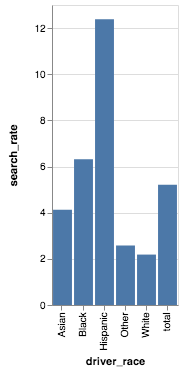

In [33]:
alt.Chart(search_rates).mark_bar().encode(x = 'driver_race', y = 'search_rate')

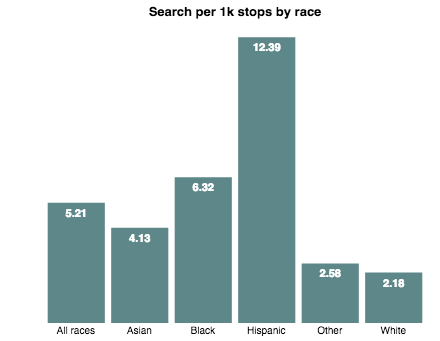

In [34]:
search_rates['driver_race'].replace({'total' : 'All races'}, inplace = True)

bars = alt.Chart(search_rates,  
          width = 400, 
          title = 'Search per 1k stops by race'
).mark_bar(
    color = '#5d8789'
).encode(
    x = alt.X(
        'driver_race', 
        axis = alt.Axis(
            title = None, 
            labelAngle = 0, 
            ticks = False, 
            domain = False),
        scale = alt.Scale(paddingOuter = 0.2)), 
    y = alt.Y(
        'search_rate:Q', 
        axis = alt.Axis(
            title = None,
            domain = False,
            ticks = False,
            labels = False,
            grid = False
        )))
text = bars.mark_text(align = 'center', baseline = 'top', dy = 5, fontWeight = 'bold', color = 'white').encode(text = alt.Text('search_rate:Q', format = '.2f'))
(bars + text).configure_view(stroke = 'transparent')

## But what if...

Some critics may argue that officers have good reason when they search somebody's vehicle and that reason may not be race. Fortunately the data contains a column that can help us check that – `contraband_found`. Basically we can check to see how often a consent_search actually turned up something illegal. 

### Work on your own, part III

This exercise has multiple parts:
1. First you need to filter the `az_stops` dataframe so you are looking at only consent searches. 
2. Then you need to create a pivot table called `hit_rates` based on the `driver_race` and the `contraband_found` columns. Convert it back to a dataframe.
3. Create a new `hit_rate` column and calculate the hit rate per 100 stops.
4. Rename the driver_race 'total' row to 'All races'

In [35]:
# filter for consent_searches
consent_searches = az_stops[az_stops.consent_search == 'consent_search']

In [36]:
# create the pivot table
hit_rates = pd.pivot_table(consent_searches, 
                           columns = 'contraband_found', 
                           index = 'driver_race', 
                           values = 'id', 
                           aggfunc = 'count', 
                           margins = True, 
                           margins_name = 'total')

hit_rates = pd.DataFrame(hit_rates.to_records())
# optional rename columns
hit_rates.rename(columns = {'FALSE' : 'miss', 'TRUE' : 'hit'}, inplace = True)
hit_rates

,driver_race,miss,hit,total
0,Asian,42,9,51
1,Black,131,52,183
2,Hispanic,1466,211,1677
3,Other,66,27,93
4,White,503,143,646
5,total,2208,442,2650


In [37]:
# calculate the hit rate
hit_rates['hit_rate'] = (hit_rates['hit'] / hit_rates['total']) * 100

hit_rates['driver_race'].replace({'total' : 'All races'}, inplace = True)

hit_rates

,driver_race,miss,hit,total,hit_rate
0,Asian,42,9,51,17.647059
1,Black,131,52,183,28.415301
2,Hispanic,1466,211,1677,12.581992
3,Other,66,27,93,29.032258
4,White,503,143,646,22.136223
5,All races,2208,442,2650,16.679245


### Coming back

Whoa. It looks like we found something amazing here. **Not only are Hispanics searched at rates much higher than any other racial/ethnicity but police find contraband on them at rates lower than any other racial/ethnic group.**

But rather than scrolling up and down the page here, let's combine our results into a single table. To do this we will use the merge function in Pandas. (If you have worked with SQL, this is very similar to a SQL join.)

In [38]:
combined = search_rates.merge(hit_rates, on = 'driver_race', how = 'inner')
combined

,driver_race,consent_search,no_search,unknown_search,total_x,search_rate,miss,hit,total_y,hit_rate
0,Asian,51,12033,266,12350,4.129555,42,9,51,17.647059
1,Black,183,26770,2019,28972,6.316443,131,52,183,28.415301
2,Hispanic,1677,125849,7877,135403,12.385250,1466,211,1677,12.581992
3,Other,93,33834,2071,35998,2.583477,66,27,93,29.032258
4,White,646,286102,8947,295695,2.184684,503,143,646,22.136223
5,All races,2650,484588,21180,508418,5.212247,2208,442,2650,16.679245


And let's clean up the columns a bit. We want to rename the `total_x` to `traffic_stops` and drop the `total_y` column since it duplicates `consent_search`. We can drop the other search columns as well as the `miss` column. We also should rename the `search_rate` and `hit_rate` columns to make more sense. While we are at it, let's re-order the columns.

In [39]:
combined.rename(columns = {'total_x' : 'traffic_stops', 'search_rate' : 'searches_per_1k_stops', 'hit_rate' : 'hits_per_100_searches'}, inplace = True)

combined = combined[['driver_race', 'traffic_stops', 'consent_search', 'hit', 'searches_per_1k_stops', 'hits_per_100_searches']].copy()
combined

,driver_race,traffic_stops,consent_search,hit,searches_per_1k_stops,hits_per_100_searches
0,Asian,12350,51,9,4.129555,17.647059
1,Black,28972,183,52,6.316443,28.415301
2,Hispanic,135403,1677,211,12.385250,12.581992
3,Other,35998,93,27,2.583477,29.032258
4,White,295695,646,143,2.184684,22.136223
5,All races,508418,2650,442,5.212247,16.679245


## Let's visualize it

Again it may help to visualize the data. Let's create a scatter plot comparing hit rates and search rates by race.

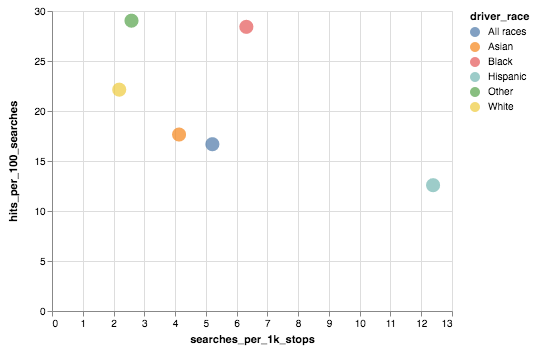

In [40]:
alt.Chart(combined).mark_circle(size = 200).encode(x = 'searches_per_1k_stops', y = 'hits_per_100_searches', color = 'driver_race')

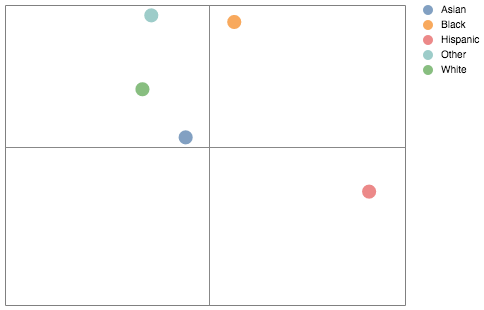

In [41]:
data_to_chart = combined[combined['driver_race'] != 'All races']
alt.Chart(
    data_to_chart,
).mark_circle(
    size = 200
).encode(
    x = alt.X(
        'searches_per_1k_stops', 
        axis = alt.Axis(
            offset = -158, 
            labels = False, 
            ticks = False, 
            grid = False, 
            title = None),
        scale = alt.Scale(domain = [-2.6,13])), 
    y = alt.Y(
        'hits_per_100_searches',
        axis = alt.Axis(
            offset = -204, 
            labels = False, 
            ticks = False, 
            grid = False, 
            title = None),
        scale = alt.Scale(domain = [3.4,30])
        ),
    color = alt.Color('driver_race', legend = alt.Legend(title = None))).configure_view(stroke = 'gray')

## Export your results

In [42]:
combined.to_csv('./results.csv', index = False)

## How can we make this better?

1. Multiple years of analysis
2. Break up by county?